# Happy or not person classifier

## Purpose

The purpose of this article is to create a classifier using Artificial Intelligence to distinguish between Happy and Sad person. For the neural network, I'm going to utilize the fast.ai framework, and for the dataset, I'll be using the DuckDuckGo Search library to download the images.

## Collecting the data

The first step in building our model is to collect the data. Here, we will import the library that can assist us with this task.

In [29]:
from duckduckgo_search import ddg_images
from fastcore.all import *

Now, the function that provide a list of URL's images

In [30]:
def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [31]:
urls = search_images('happy person', max_images=1)
urls[0]

'https://www.allprodad.com/wp-content/uploads/2021/03/05-12-21-happy-people.jpg'

We need to download the images, so we are going to use the fastdownload function from the fast.ai library.

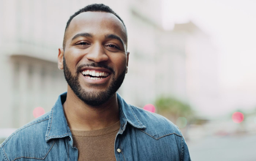

In [32]:
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.data import *

dest = 'happy.jpg'
download_url(urls[0], dest, show_progress=True)

img01 = Image.open(dest)
img01.to_thumb(256, 256)

With everything working well, let's proceed to download the dataset.

In [ ]:
from time import sleep

searchs = 'happy', 'sad'
path = Path('src')
for search in searchs:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{search} person'))
    sleep(10)
    download_images(dest, urls=search_images(f'{search} person in the rain'))
    sleep(10)
    download_images(dest, urls=search_images(f'{search} person in the party'))
    sleep(10)
    resize_images(path/search, max_size=400, dest=path/search)

We also need to check if any files are corrupted or unsuitable for use.

In [63]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

## Train our model

The object described above is a DataBlock, which contains the data used to train a machine learning model. Here is a summary of the parameters within the DataBlock() function:

1. **blocks=(ImageBlock, CategoryBlock)**: This parameter specifies the data blocks being used in the DataBlock. It indicates that we have two blocks: ImageBlock for handling the input images and CategoryBlock for categorizing them into health or junk classes. It's worth noting that you can have more than two parameters, but a minimum of two is required.

2. **get_items=get_image_files**: This parameter is associated with a function that retrieves the image files for the Data Loaders. It fetches the image data for training and validation.

3. **splitter=RandomSplitter(valid_pct=0.2, seed=42)**: This parameter defines how the dataset will be split for training and validation. In this case, it specifies that 20% of the images will be reserved for validation, while 80% will be used for training. The "seed" parameter ensures that this 80/20 split remains consistent across different runs by providing a random seed for the process.

4. **get_y=parent_label**: This function is used to separate the CategoryBlock based on the parent folder's label. It helps categorize the images by their respective classes.

5. **item_tfms=[Resize(192, method='squish')]**: In machine learning, models often require a consistent input size. This parameter sets the default input size for our models to be 192x192 pixels, using the "squish" method to resize and prepare the images for model training.

By configuring these parameters in the DataBlock, you define how your data will be loaded, split, labeled, and preprocessed for training a machine learning model.


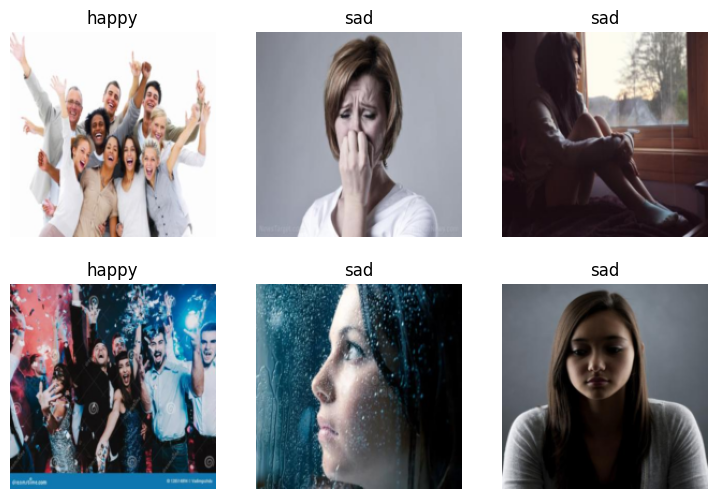

In [67]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

With everything working well, although some errors are common, let's continue with our model training.

The function **vision_learner** mentioned above is the method responsible for training our model. Its first parameter is the Data Block, which contains all the images and configurations we've selected. Additionally, we utilize the **resnet18** neural network, which has already been pretrained for vision-related tasks. Finally, the **metrics** parameter is used to evaluate our model's performance, primarily based on error rate.

In [68]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.211148,1.325317,0.428571,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.656590,0.782318,0.285714,00:10
1,0.500760,0.744146,0.274725,00:09
2,0.380262,0.734222,0.241758,00:11
3,0.290005,0.705495,0.241758,00:11
4,0.233538,0.705161,0.230769,00:10


## Validate our model

To test our model, we need to download the test data, which consists of both health and junk photos. We will utilize the same function that we have already employed previously.

It is a happy person
Probability: 0.9997


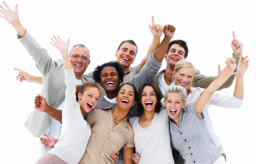

In [72]:
download_url(search_images('happy person', max_images=10)[6], 'happy.jpg', show_progress=False)
is_happy,_,probs = learn.predict(PILImage.create('happy.jpg'))
print(f'It is a {is_happy} person')
print(f'Probability: {probs[0]:.4f}')
Image.open('happy.jpg').to_thumb(256,256)

It is a sad person
Probability: 0.0023


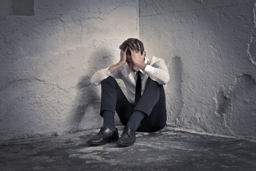

In [73]:
download_url(search_images('sad person', max_images=10)[6], 'sad.jpg', show_progress=False)
is_sad,_,probs = learn.predict(PILImage.create('sad.jpg'))
print(f'It is a {is_sad} person')
print(f'Probability: {probs[0]:.4f}')
Image.open('sad.jpg').to_thumb(256,256)

## Conclusion

Based on the results, the model provided the correct output. However, the probability of "Sad Person" is too low. Without further testing, this "Sad Person" probability may be attributed to the input size used during model training.